In [120]:
# This notebook plots predicted concentration gradients for different wounding conditions 
import sys
import os

sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.special import expi
from scipy.stats import gaussian_kde
import random
import emcee


In [193]:
filesuffix = "_flatpriors_farhalf_1x_t2"

# Load inferred parameters for each data type 
Post_attractant_control = emcee.backends.HDFBackend('../data/Attractant_inference/attractant_inference_CTR_revision'+filesuffix+'.h5')
Post_attractant_mcr = emcee.backends.HDFBackend('../data/Attractant_inference/attractant_inference_MCR_revision'+filesuffix+'.h5')

In [176]:
# calculate autocorrelation times (this might take a while... ~1-10min) to estimate burn-in and thinning parameters, then retrieve flattened samples
def calculate_burnin_thin(sampler):
    tau = sampler.get_autocorr_time(tol=0) # use tol=0 here as we don't expect all parameters to converge (some can't be inferred well)
    burnin = int(2 * np.max(tau))
    thin = int(np.min(tau))
    print("burn-in: {0}".format(burnin))
    print("thin: {0}".format(thin))
    return burnin, thin

burnin_ctr, thin_ctr = calculate_burnin_thin(Post_attractant_control)
burnin_mcr, thin_mcr = calculate_burnin_thin(Post_attractant_mcr)

posterior_samples_control = Post_attractant_control.get_chain(discard=burnin_ctr, thin=thin_ctr, flat = True)
posterior_samples_mcr = Post_attractant_mcr.get_chain(discard=burnin_mcr, thin=thin_mcr, flat = True)
# randomly subsample N_sub samples from the posterior  (this speeds up subsequent plotting and mode calculation)
N_sub = 10000
if N_sub < posterior_samples_control.shape[0]:
    posterior_samples_control = posterior_samples_control[np.random.choice(posterior_samples_control.shape[0], N_sub, replace=False)]
if N_sub < posterior_samples_mcr.shape[0]:
    posterior_samples_mcr = posterior_samples_mcr[np.random.choice(posterior_samples_mcr.shape[0], N_sub, replace=False)]

burn-in: 67844
thin: 3074
burn-in: 12245
thin: 1110


In [177]:
# Multiple wound function, using the Exponential Integral
def concentration_multiple_sources(x, y, ts, source_locations, q,D, tau):
    concentration_sum = np.zeros_like(x)
    
    for qx, qy in source_locations:
        r = np.sqrt((x - qx)**2 + (y - qy)**2)
        factor = q / (4 * np.pi * D)
        
        if ts < tau:
            concentration_sum += -factor * expi(-r**2 / (4 * D * ts))
        else:
            concentration_sum += factor * (expi(-r**2 / (4 * D * (ts - tau))) - expi(-r**2 / (4 * D * ts)))
    
    return concentration_sum

In [178]:
# Circle function for source points
def circle(r, thetas):
    xs = r * np.cos(thetas)
    ys = r * np.sin(thetas)
    return xs, ys  # Returning xs and ys as a tuple

# Create an array of angles from 0 to π (180 degrees)
theta_half = np.linspace(0, np.pi, 10)
theta_full = np.delete(np.linspace(0, 2*np.pi, 20), -1) # last element is present twice, so remove it to avoid a double strength source

# Define the radius of the circle
wound_radius = 37.0

# Calculate the x and y coordinates for points on the half-circle and full circle
xs_half, ys_half = circle(wound_radius, theta_half) 
xs_full, ys_full = circle(wound_radius, theta_full)

def location_of_sources(halfwound_on, two_wounds=False):
    if (halfwound_on == True) & (two_wounds == False):
        source_locations = [(xs_half[i],ys_half[i]) for i in range(len(xs_half))]
    elif (two_wounds == True) & (halfwound_on == False): # two wild type wounds
        source_locations = [(xs_full[i],ys_full[i] + 80) for i in range(len(xs_full))]
        source_locations += [(xs_full[i],ys_full[i] - 80) for i in range(len(xs_full))]
    elif (two_wounds == True) & (halfwound_on == True): # one wild type wound and one Mcr kd wound
        source_locations = [(xs_full[i],ys_full[i] + 80) for i in range(len(xs_full))]
    else:
        source_locations = [(xs_full[i],ys_full[i]) for i in range(len(xs_full))]
    return source_locations
    
def strength_of_sources(halfwound_on, flow_rate):
    if halfwound_on == True:
        source_strength = flow_rate / 2 / len(xs_half)
    else:
        source_strength = flow_rate / len(xs_full)
    return source_strength

def kde_mode(values):
    pdf_estimate = gaussian_kde(values)
    return values[np.argmax(pdf_estimate.pdf(values))]

def plot_posterior_kde(samples_ctr, samples_mcr, param_index, xlabelstring, xlim=0, savefilename=None):
    # Create a histogram plot with seaborn
    sns.kdeplot(samples_ctr[:,param_index],label='Control', clip=(0,np.Inf))
    sns.kdeplot(samples_mcr[:,param_index], label='MCR KD', clip=(0,np.Inf))

    # Customize the plot
    plt.xlabel(xlabelstring)
    plt.ylabel('Density')
    if xlim>0:
        plt.xlim([0,xlim])
    plt.legend()
    plt.grid(True)
    if savefilename:
        plt.savefig('Figures/PosteriorParameterPlots/'+savefilename)

    # Show the plot
    plt.show()

In [179]:
# extract mean parameters from Posterior distributions, i.e. Diffusion coefficient, flow rate, tau 
D_control = kde_mode(posterior_samples_control[:,1])
q_control = kde_mode(posterior_samples_control[:,0]) 
tau_control = kde_mode(posterior_samples_control[:,2]) 
print(f'D_ctr = {D_control:.1f}; q_ctr = {q_control:.1f}; tau_ctr = {tau_control:.1f}')

D_mcr = kde_mode(posterior_samples_mcr[:,1])
q_mcr = kde_mode(posterior_samples_mcr[:,0]) 
tau_mcr = kde_mode(posterior_samples_mcr[:,2]) 
print(f'D_mcr = {D_mcr:.1f}; q_mcr = {q_mcr:.1f}; tau_mcr = {tau_mcr:.1f}')

D_ctr = 46.9; q_ctr = 316.7; tau_ctr = 0.2
D_mcr = 117.9; q_mcr = 124.5; tau_mcr = 5.2


In [180]:
# ## use this only to generate diffusion plots as per Weavers, Liepe et al.
# filesuffix ="_WeaversLiepePrediction"
# D_control = 200
# q_control = 1750 # prior mean
# tau_control = 18 

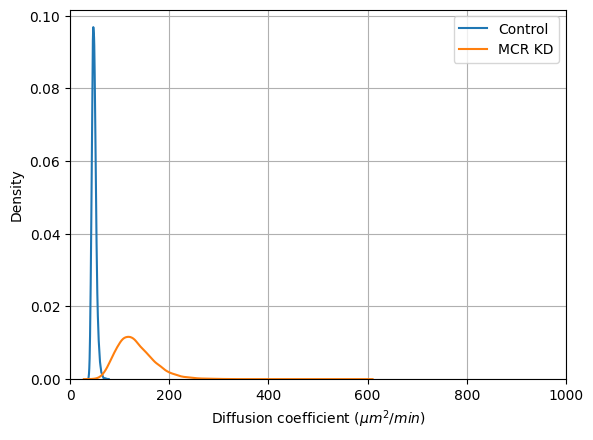

In [181]:
plot_posterior_kde(posterior_samples_control, posterior_samples_mcr, 
                   1, 'Diffusion coefficient ($\mu m^2/min$)', xlim=1000, savefilename='Diffusion_coefficients'+filesuffix+'.pdf')

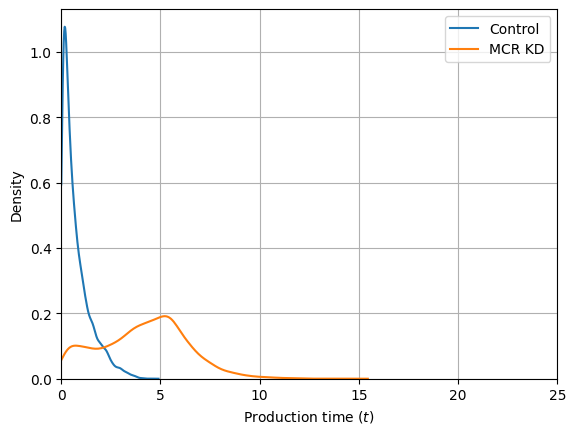

In [182]:
plot_posterior_kde(posterior_samples_control, posterior_samples_mcr, 
                   2, 'Production time ($t$)', xlim=25,
                   savefilename='Production_time'+filesuffix+'.pdf')

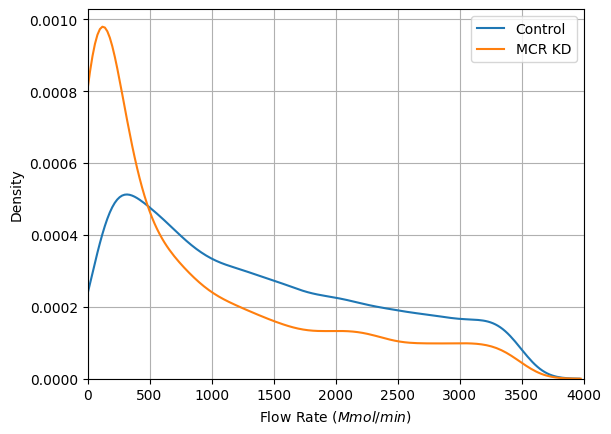

In [183]:
plot_posterior_kde(posterior_samples_control, posterior_samples_mcr, 
                   0, 'Flow Rate ($Mmol / min$)', xlim=4000,
                   savefilename='Flow_rate'+filesuffix+'.pdf')

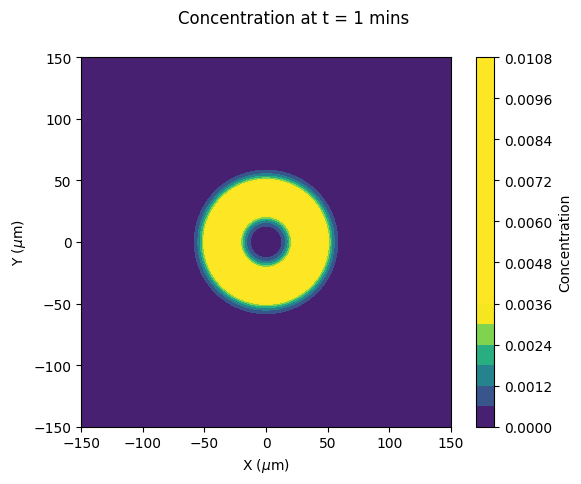

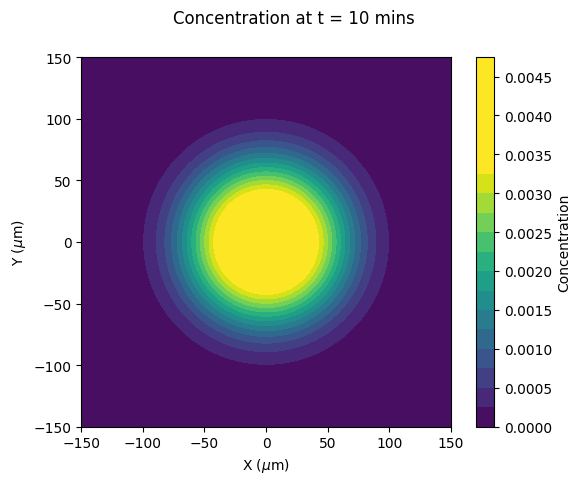

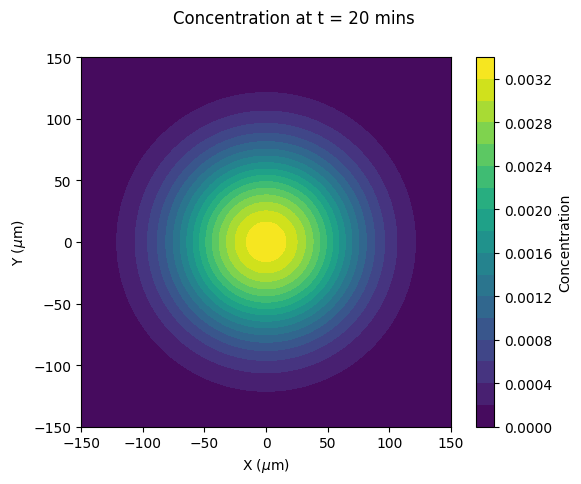

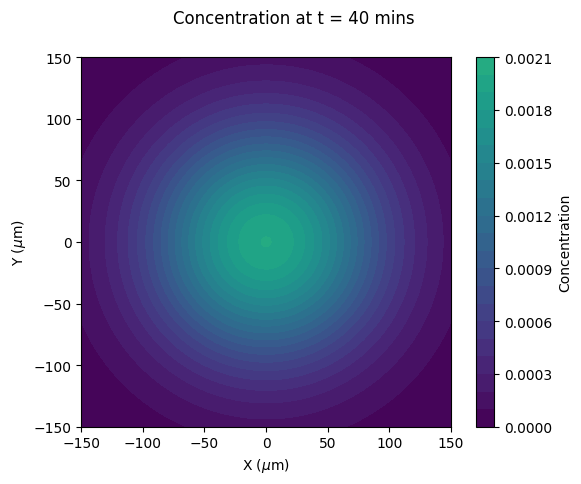

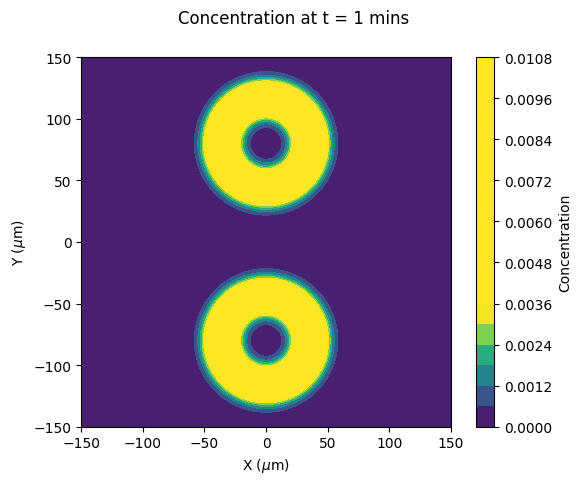

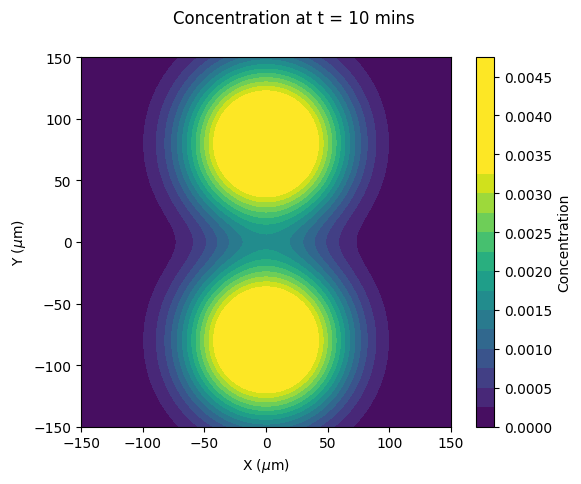

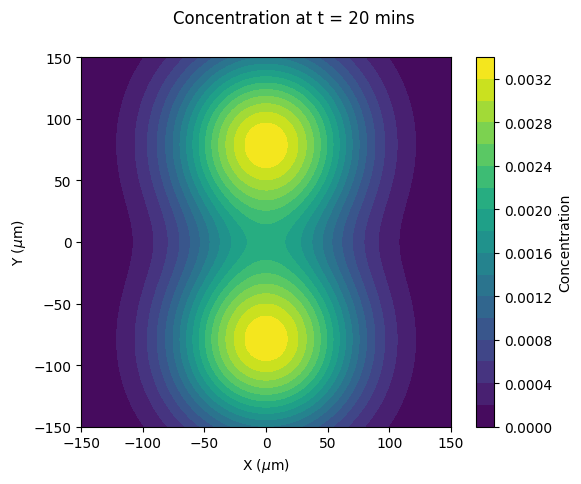

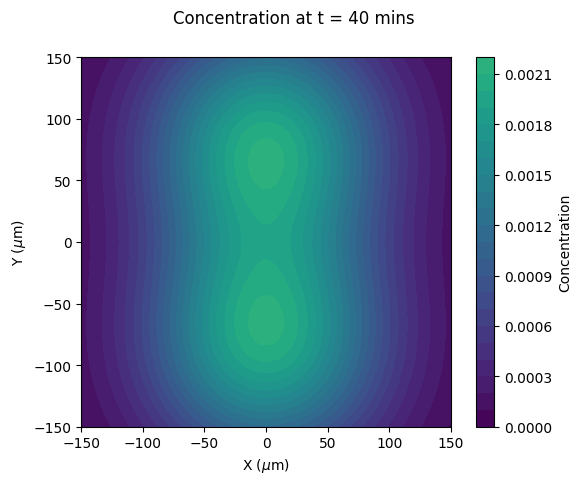

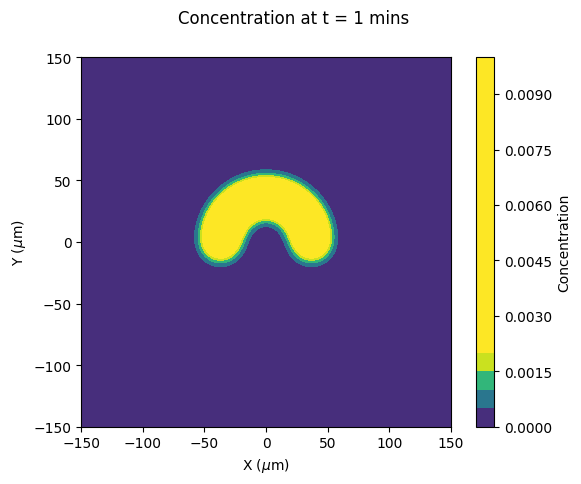

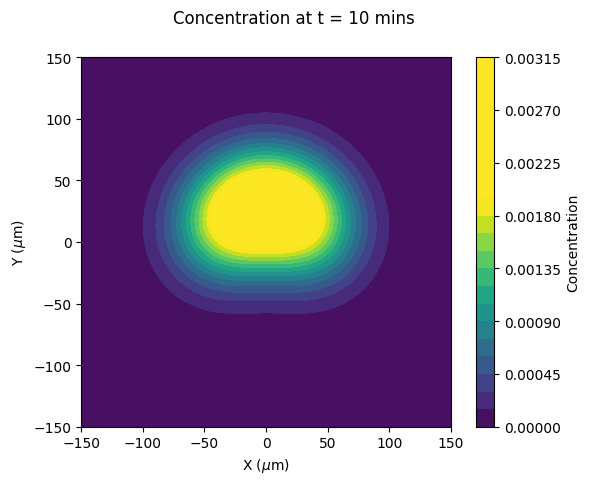

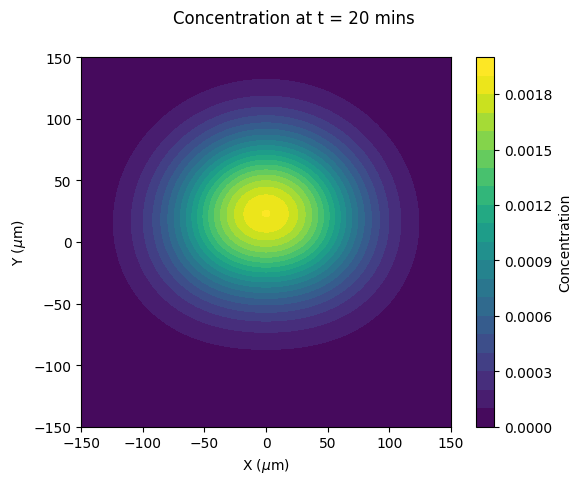

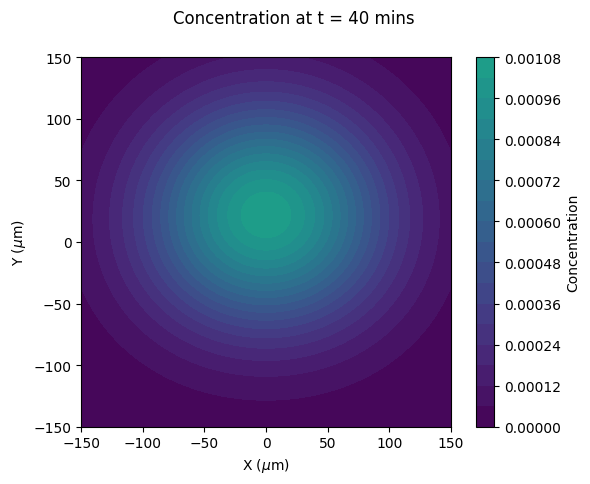

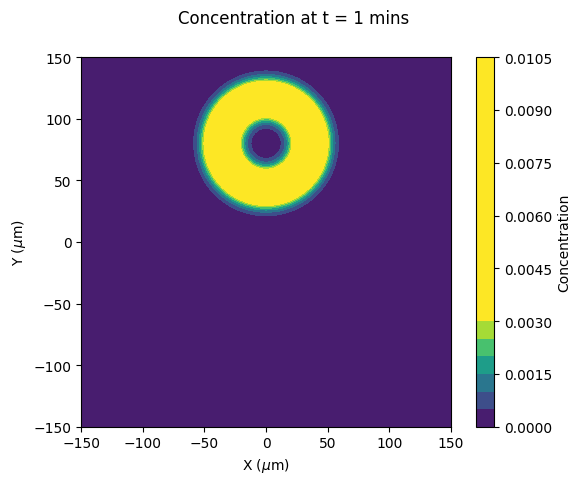

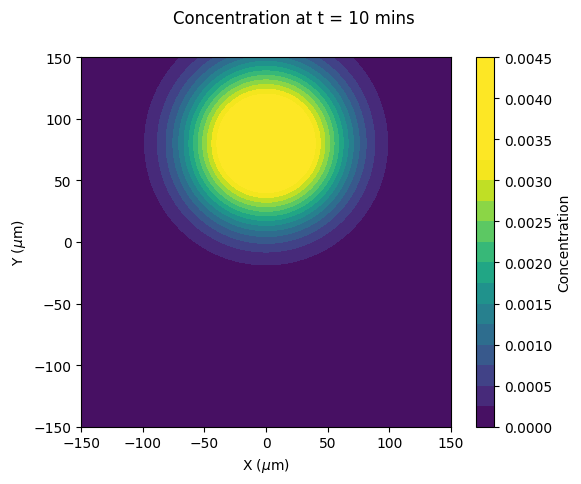

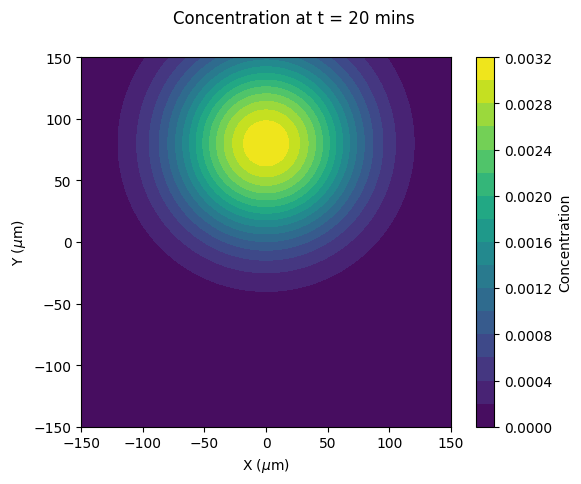

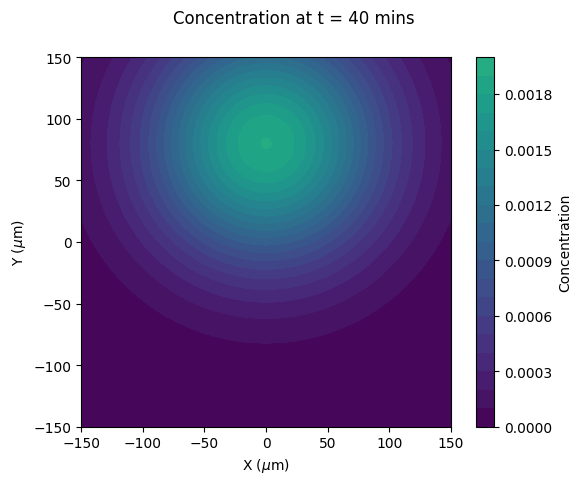

In [184]:
# Produce heatmap of chemoattractant concentration 
# Half wound on or off, if off two wounds are plotted instead

L = 150 # sets the range of plot from -L to L
# Define the grid 
nPoints = 500
x = np.linspace(-L, L, nPoints)
y = np.linspace(-L, L, nPoints)
distance = np.linspace(-L,L,nPoints) # Distance in microns for plotting
X, Y = np.meshgrid(x, y)

two_wounds = True
for halfwound_on in [False, True]:
    for two_wounds in [False, True]:
        # Define the positions of the point sources
        source_locations = location_of_sources(halfwound_on, two_wounds)
        source_strength = strength_of_sources(halfwound_on, q_control)

        max_concentration = concentration_multiple_sources(X, Y, 20, source_locations, source_strength, D_control, tau_control)
        max_concentration = max_concentration.max()

        for ts in [1, 10, 20, 40]:
            # Set the values of ts, D, and tau
            # ts = 20 # current time - min

            # Calculate the concentration at each point in the grid
            concentration = concentration_multiple_sources(X, Y, ts, source_locations, source_strength, D_control, tau_control)

            # levels = np.linspace(concentration.min(),concentration.max(), 20)

            # plotting 
            fig, ax = plt.subplots(1)
            ax.set_aspect('equal')

            im = ax.contourf(X, Y, concentration, levels=20, vmin=0, vmax=max_concentration)

            ax.set_xlabel('X ($\mu$m)')
            ax.set_ylabel('Y ($\mu$m)')
            cbar = fig.colorbar(im)
            cbar.set_label('Concentration')

            fig.suptitle(f'Concentration at t = {int(ts)} mins')
            if (halfwound_on == True) & (two_wounds == False):
                plt.savefig(f"Figures/DiffusionPlots/Half wound concentration at t = {ts}"+filesuffix+".pdf")
            elif (two_wounds == True) & (halfwound_on == False):
                plt.savefig(f"Figures/DiffusionPlots/Two wound concentration at t = {ts}"+filesuffix+".pdf")
            elif (two_wounds == True) & (halfwound_on == True):
                plt.savefig(f"Figures/DiffusionPlots/Two wound one KD concentration at t = {ts}"+filesuffix+".pdf")
            else:
                plt.savefig(f"Figures/DiffusionPlots/Single wound concentration at t = {ts}"+filesuffix+".pdf")
            plt.show()


In [185]:
max_concentration

0.003175708159567814

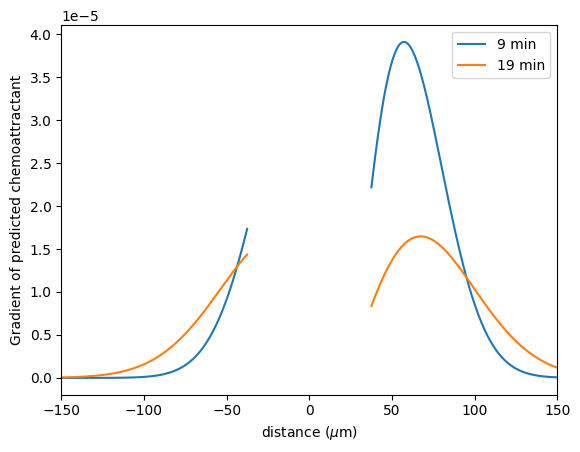

In [186]:
# next will plot line plots of the predicted bias for half wound data
# this needs to be averaged over multiple time-windows to compare with data
# Define the positions of the point sources
source_locations = location_of_sources(halfwound_on=True, two_wounds=False)
source_strength = strength_of_sources(halfwound_on=True, flow_rate=q_control)
# wound_indices = np.abs(distance)<wound_radius
wound_edge_indices = [next(i for i, x in enumerate(distance) if x>-wound_radius), next(i for i, x in enumerate(distance) if x>wound_radius)]
color_list = ['tab:blue','tab:orange', 'tab:orange']
alpha_list = [1, 1]
for i, ts in enumerate([9, 19]):
    concentration_half = concentration_multiple_sources(X, Y, ts, source_locations, source_strength,D_control, tau_control)
    absolute_concentration_grad = np.absolute(np.gradient(concentration_half[:, int(nPoints/2)]))
    plt.plot(distance[:wound_edge_indices[0]],absolute_concentration_grad[:wound_edge_indices[0]],color_list[i], alpha=alpha_list[i])
    plt.plot(distance[wound_edge_indices[1]:],absolute_concentration_grad[wound_edge_indices[1]:],color_list[i], alpha=alpha_list[i], label=str(ts)+' min')
    # plt.plot(distance[wound_indices],absolute_concentration_grad[wound_indices],'k--')
plt.legend()
plt.xlim(-150,150)
plt.xlabel("distance ($\mu$m)")
plt.ylabel("Gradient of predicted chemoattractant")
plt.savefig(f"Figures/PredictedBiasPlots/Half wound predicted bias"+filesuffix+".pdf")
plt.show()

In [187]:
# # plot muliple lines for different samples from the posterior distribution
# # CHANGE THIS TO SAMPLE JOINTLY RATHER THAN MARGINALS
# # generate some random samples to plot
# num_samples_total = len(posterior_samples_control)
# num_samples_to_plot = 100
# # now choose 100 random integers between 0 and num_samples_total
# samples_to_plot = np.random.randint(0, num_samples_total, num_samples_to_plot)

# multi_gradients = []
# for i in range(num_samples_to_plot):
#     this_sample = samples_to_plot[i]
#     concentration_half = concentration_multiple_sources(X, Y, 5, source_locations, strength_of_sources(halfwound_on=True, flow_rate=posterior_samples_control[this_sample,0]),
#                                                         posterior_samples_control[this_sample,1], posterior_samples_control[this_sample,2])
#     multi_gradients.append(np.absolute(np.gradient(concentration_half[:,int(nPoints/2)])))

In [188]:
# for i in range(len(multi_gradients)):
#     plt.plot(distance,multi_gradients[i], 'r', alpha = 0.1)
# plt.show()

In [189]:
# Two-wound plots
source_locations2 = location_of_sources(halfwound_on=False, two_wounds=True)
source_strength2 = strength_of_sources(halfwound_on=False, flow_rate=q_control)

concentration_1 = concentration_multiple_sources(X, Y, 1, source_locations2, source_strength2, D_control, tau_control)
concentration_10 = concentration_multiple_sources(X, Y, 10, source_locations2, source_strength2, D_control, tau_control)
concentration_20 = concentration_multiple_sources(X, Y, 20, source_locations2, source_strength2, D_control, tau_control)
concentration_40 = concentration_multiple_sources(X, Y, 40, source_locations2, source_strength2, D_control, tau_control)

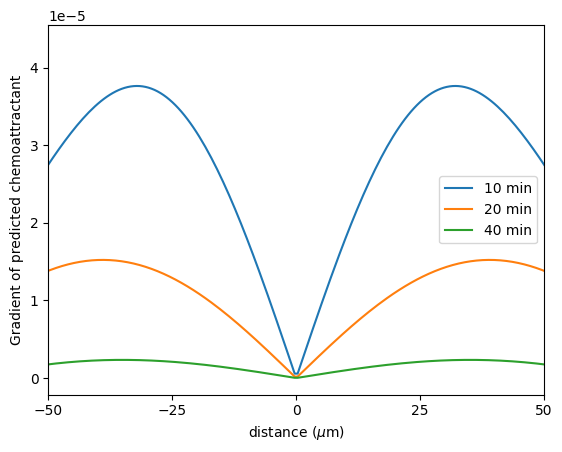

In [190]:
plt.plot(distance,np.absolute(np.gradient(concentration_10[:,int(nPoints/2)])), label = "10 min")
plt.plot(distance,np.absolute(np.gradient(concentration_20[:,int(nPoints/2)])), label = "20 min")
plt.plot(distance,np.absolute(np.gradient(concentration_40[:,int(nPoints/2)])), label = "40 min")

# plt.ylim(0,0.0025)
plt.xlim(-50,50)
plt.xticks(np.linspace(-50,50,5))
plt.legend()
plt.xlabel("distance ($\mu$m)")
plt.ylabel("Gradient of predicted chemoattractant")
plt.savefig("Figures/PredictedBiasPlots/Two wound predicted bias"+filesuffix+".pdf")
plt.show()

In [191]:
# two wounds with one KD
source_locations2KD = location_of_sources(halfwound_on=True, two_wounds=True)
source_strength2KD = strength_of_sources(halfwound_on=False, flow_rate=q_control)

concentration_1KD = concentration_multiple_sources(X, Y, 1, source_locations2KD, source_strength2KD, D_control, tau_control)
concentration_10KD = concentration_multiple_sources(X, Y, 10, source_locations2KD, source_strength2KD, D_control, tau_control)
concentration_20KD = concentration_multiple_sources(X, Y, 20, source_locations2KD, source_strength2KD, D_control, tau_control)
concentration_40KD = concentration_multiple_sources(X, Y, 40, source_locations2KD, source_strength2KD, D_control, tau_control)

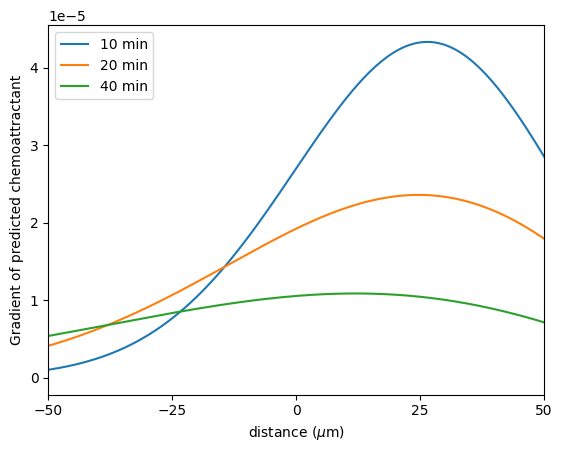

In [192]:
plt.plot(distance,np.absolute(np.gradient(concentration_10KD[:,int(nPoints/2)])), label = "10 min")
plt.plot(distance,np.absolute(np.gradient(concentration_20KD[:,int(nPoints/2)])), label = "20 min")
plt.plot(distance,np.absolute(np.gradient(concentration_40KD[:,int(nPoints/2)])), label = "40 min")

# plt.ylim(0,0.0026)
plt.xlim(-50,50)
plt.xticks(np.linspace(-50,50,5))
plt.legend()
plt.xlabel("distance ($\mu$m)")
plt.ylabel("Gradient of predicted chemoattractant")
plt.savefig("Figures/PredictedBiasPlots/Two wound KD predicted bias"+filesuffix+".pdf")
plt.show()